## POS tagging using modified Viterbi

### 1. Project Description

One of the reasons for loss of accuracy in POS tagging (plain vanilla viterbi algorithm) is due to the presence of unknown words. Hence, we need to modify the algorithm to tackle the problem of unknown words. There are multiple ways to tackle these unknown words. However, in this project, we will implement two techniques to tackle unknown words and improve the accuracy

### 2. Data Preparation

In [1]:
#Importing libraries required for the tagging
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import nltk
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Suman.Khanal\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
# Reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# Checkinng first few tagged sentences
print(nltk_data[:3])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and validation set witht 95% training set and 5% for validation set
# Only 5% is taken as validation as the runtime would be extremely high otherwise
random.seed(1234)
train_set, validation_set = train_test_split(nltk_data,test_size=0.05)

# Checking the size of train and validation set
print(len(train_set))
print(len(validation_set))

3718
196


In [5]:
# Checking tagging of first few sentence of the train data of universal dataset
print(train_set[:3])

[[('Chateau', 'NOUN'), ('Yquem', 'NOUN'), (',', '.'), ('the', 'DET'), ('leading', 'VERB'), ('Sauternes', 'NOUN'), (',', '.'), ('now', 'ADV'), ('goes', 'VERB'), ('for', 'ADP'), ('well', 'ADV'), ('over', 'ADV'), ('$', '.'), ('100', 'NUM'), ('*U*', 'X'), ('a', 'DET'), ('bottle', 'NOUN'), ('for', 'ADP'), ('a', 'DET'), ('lighter', 'ADJ'), ('vintage', 'NOUN'), ('like', 'ADP'), ('1984', 'NUM'), (';', '.'), ('the', 'DET'), ('spectacularly', 'ADV'), ('rich', 'ADJ'), ('1983', 'NUM'), ('runs', 'VERB'), ('$', '.'), ('179', 'NUM'), ('*U*', 'X'), ('.', '.')], [('The', 'DET'), ('rule', 'NOUN'), ('also', 'ADV'), ('prohibits', 'VERB'), ('funding', 'NOUN'), ('for', 'ADP'), ('activities', 'NOUN'), ('that', 'DET'), ('``', '.'), ('*T*-137', 'X'), ('encourage', 'VERB'), (',', '.'), ('promote', 'VERB'), ('or', 'CONJ'), ('advocate', 'VERB'), ('abortion', 'NOUN'), ('.', '.'), ("''", '.')], [('That', 'DET'), ("'s", 'VERB'), ('almost', 'ADV'), ('$', '.'), ('10', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('equity', 'N

In [6]:
# Getting list of tagged words from the train dataset
# Printing the length of list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95464

In [7]:
# Checking first few tagged words
train_tagged_words[:3]

[('Chateau', 'NOUN'), ('Yquem', 'NOUN'), (',', '.')]

In [8]:
# Creating the list of token from the list of tagged words created above
tokens = [pair[0] for pair in train_tagged_words]

In [9]:
# Creating the vocabulary of the words and  checking the size of the vocabulory
V = set(tokens)
print(len(V))

12079


Observation: We observed that 12079 uniques words have been tagged in the training data set

In [10]:
# Creating a set of tags and checking the size of the tags
tags = ([pair[1] for pair in train_tagged_words])
T=set(tags)
len(T)

12

Observation: We observe that there are 12 POS tags used. Lets find the name of tags.

In [11]:
# Checking the names of the tags used
print(T)

{'CONJ', 'ADP', '.', 'PRT', 'DET', 'ADV', 'ADJ', 'NUM', 'VERB', 'X', 'PRON', 'NOUN'}


In [12]:
# Checking the number of times each tag is used in the train data set
from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NOUN': 27415,
         '.': 11108,
         'DET': 8279,
         'VERB': 12853,
         'ADV': 3018,
         'ADP': 9311,
         'NUM': 3352,
         'X': 6257,
         'ADJ': 6082,
         'CONJ': 2161,
         'PRT': 3051,
         'PRON': 2577})

Observation:
    1. It is observed that NOUN has been tagged most followed by VERB and '.'

In [13]:
# Creating a zero matrix and computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [14]:
# Defining a function to compute probability of word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [15]:
# Checking the functionality of the function defined above with few words from the training data

# addition
print("\n", "addition")
print(word_given_tag('addition', 'ADJ'))
print(word_given_tag('addition', 'VERB'))
print(word_given_tag('addition', 'NOUN'), "\n")

# the
print("\n", "the")
print(word_given_tag('the', 'DET'))
print(word_given_tag('the', 'PRON'))
print(word_given_tag('the', 'VERB'))

# damages
print("\n", "damages")
print(word_given_tag('damages', 'NOUN'))
print(word_given_tag('damages', 'ADJ'))
print(word_given_tag('damages', 'verb'))


 addition
(0, 6082)
(0, 12853)
(21, 27415) 


 the
(3841, 8279)
(0, 2577)
(0, 12853)

 damages
(5, 27415)
(0, 6082)
(0, 0)


In [16]:
# Computing tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [17]:
# Creating t x t transition matrix of tags
# Each column is t2, each row is t1
# Thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
# Checking the tag matrix
tags_matrix

array([[4.62748721e-04, 5.32161035e-02, 3.47061530e-02, 5.09023620e-03,
        1.19389169e-01, 5.22906072e-02, 1.18926421e-01, 4.21101339e-02,
        1.55946314e-01, 8.32947716e-03, 5.83063401e-02, 3.51226270e-01],
       [7.51798972e-04, 1.68617759e-02, 3.97379436e-02, 1.50359794e-03,
        3.23917955e-01, 1.34249814e-02, 1.07399851e-01, 6.22919127e-02,
        8.05498846e-03, 3.50123495e-02, 6.93803057e-02, 3.21662545e-01],
       [5.84263578e-02, 9.03853104e-02, 9.36262161e-02, 2.34065531e-03,
        1.74108744e-01, 5.33849485e-02, 4.49225791e-02, 8.04825351e-02,
        8.77745748e-02, 2.71876119e-02, 6.46381006e-02, 2.22632334e-01],
       [1.63880689e-03, 1.99934449e-02, 4.35922630e-02, 1.96656841e-03,
        1.02917075e-01, 9.50508006e-03, 8.45624357e-02, 5.73582426e-02,
        3.99213374e-01, 1.37659786e-02, 1.83546375e-02, 2.47132093e-01],
       [4.83150128e-04, 9.30063985e-03, 1.82389170e-02, 1.20787532e-04,
        5.43543929e-03, 1.28034791e-02, 2.03526989e-01, 2.10

In [19]:
# Converting the matrix to a dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [20]:
# Checking the dataframe for the probability of tag T1 given tag T2
tags_df

,CONJ,ADP,.,PRT,DET,ADV,ADJ,NUM,VERB,X,PRON,NOUN
CONJ,0.000463,0.053216,0.034706,0.005090,0.119389,0.052291,0.118926,0.042110,0.155946,0.008329,0.058306,0.351226
ADP,0.000752,0.016862,0.039738,0.001504,0.323918,0.013425,0.107400,0.062292,0.008055,0.035012,0.069380,0.321663
.,0.058426,0.090385,0.093626,0.002341,0.174109,0.053385,0.044923,0.080483,0.087775,0.027188,0.064638,0.222632
PRT,0.001639,0.019993,0.043592,0.001967,0.102917,0.009505,0.084562,0.057358,0.399213,0.013766,0.018355,0.247132
DET,0.000483,0.009301,0.018239,0.000121,0.005435,0.012803,0.203527,0.021017,0.039739,0.045899,0.003624,0.639812
ADV,0.006958,0.118290,0.134858,0.013585,0.069914,0.079854,0.131544,0.031478,0.343936,0.023857,0.014911,0.030815
ADJ,0.016606,0.077113,0.065439,0.010852,0.004933,0.004768,0.066426,0.020552,0.012003,0.021210,0.000658,0.699441
NUM,0.013425,0.035501,0.118138,0.027446,0.003282,0.002983,0.032518,0.185263,0.017601,0.209726,0.001193,0.352924
VERB,0.005524,0.090718,0.034778,0.031432,0.134132,0.082004,0.065432,0.023030,0.168910,0.217226,0.035478,0.111336
X,0.010069,0.143519,0.162378,0.183634,0.056257,0.025891,0.017261,0.002717,0.206329,0.074636,0.054819,0.062490


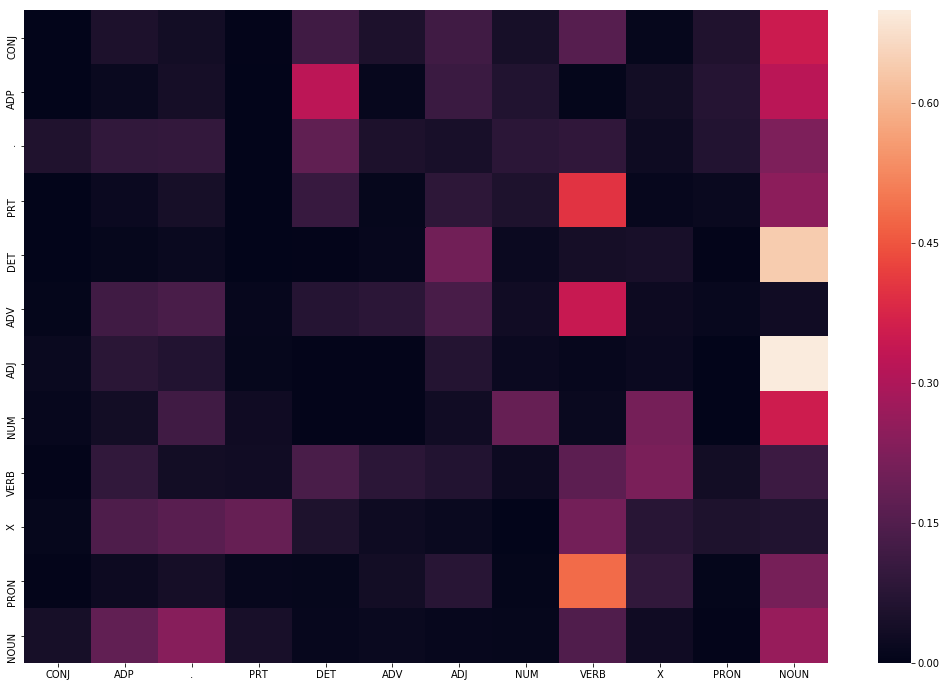

In [21]:
# For more visibility checking the heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

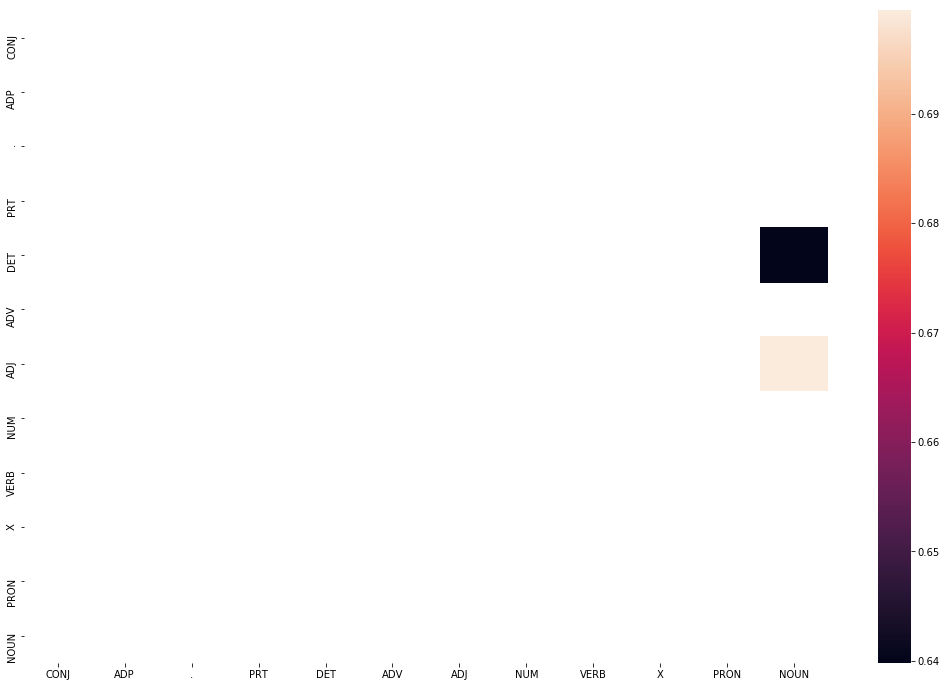

In [22]:
# Cheking the frequency tags
# Filtering the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### 3. Build the vanilla Viterbi based POS tagger

In [23]:
#Checking the length of tain tagged words
len(train_tagged_words)

95464

In [24]:
# Defining a function for plain vanilla Viterbi Heuristic

def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [25]:
# Creating a list of words in the test dataset
validation_tagged_words = [tup[0] for sent in validation_set for tup in sent]

In [26]:
# Checking few words from validation tagged words
validation_tagged_words[:5]

['*-1', 'Crude', 'as', 'they', 'were']

In [27]:
# Checking the list of validation tagged words
len(validation_tagged_words)

5212

#### 3.1 Implementing plain vanilla on the validation dataset

In [28]:
# Callig the above defined plain valina viterbi heuritc to tag the validation sentences
start = time.time()
tagged_seq_plain = Viterbi(validation_tagged_words)
end = time.time()
difference = end-start

In [29]:
# Checking the time taking to run the plain vanilla viterbi on validation dataset
print("Time taken in seconds: ", difference)
print(tagged_seq_plain)

Time taken in seconds:  1060.3660340309143
[('*-1', 'X'), ('Crude', 'ADJ'), ('as', 'ADP'), ('they', 'PRON'), ('were', 'VERB'), ('*?*', 'X'), (',', '.'), ('these', 'DET'), ('early', 'ADJ'), ('PCs', 'NOUN'), ('triggered', 'VERB'), ('explosive', 'CONJ'), ('product', 'NOUN'), ('development', 'NOUN'), ('in', 'ADP'), ('desktop', 'CONJ'), ('models', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('home', 'NOUN'), ('and', 'CONJ'), ('office', 'NOUN'), ('.', '.'), ('Researchers', 'CONJ'), ('at', 'ADP'), ('American', 'ADJ'), ('Telephone', 'NOUN'), ('&', 'CONJ'), ('Telegraph', 'NOUN'), ('Co.', 'NOUN'), ("'s", 'PRT'), ('Bell', 'NOUN'), ('Laboratories', 'NOUN'), ('reported', 'VERB'), ('0', 'X'), ('they', 'PRON'), ('raised', 'VERB'), ('the', 'DET'), ('electrical', 'ADJ'), ('current-carrying', 'ADJ'), ('capacity', 'NOUN'), ('of', 'ADP'), ('new', 'ADJ'), ('superconductor', 'NOUN'), ('crystals', 'NOUN'), ('by', 'ADP'), ('a', 'DET'), ('factor', 'NOUN'), ('of', 'ADP'), ('100', 'NUM'), (',', '.'), ('*-1', 'X'), 

In [30]:
# Creating a list with tuples with words and tags from the validation data set
validation_run_base = [tup for sent in validation_set for tup in sent]

In [31]:
# Checking fist three tuples of words and tags from the validation dataset
validation_run_base[:3]

[('*-1', 'X'), ('Crude', 'ADJ'), ('as', 'ADP')]

In [32]:
# Checking the accuracy of predicted tags from the plain vanilla viterbi
check = [i for i, j in zip(tagged_seq_plain, validation_run_base) if i == j] 

In [33]:
# Checking the accuracy of predicted tags from the plain vanilla viterbi
# Calculating the accuracy
accuracy = len(check)/len(tagged_seq_plain)

In [34]:
# Printing the accuracy
accuracy

0.909247889485802

Observation: We observe that with plain vanilla viterbi we are able to get the accuracy of XXXX

In [35]:
# Identifying the incorrectly tagged cases
incorrect_tagged_cases_plain = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_plain, validation_run_base)) if j[0]!=j[1]]

In [36]:
# Checking the cases which are incorrectly identified by the plain vanilla viterbi
incorrect_tagged_cases_plain

[[('triggered', 'VERB'), (('explosive', 'CONJ'), ('explosive', 'ADJ'))],
 [('in', 'ADP'), (('desktop', 'CONJ'), ('desktop', 'NOUN'))],
 [('.', '.'), (('Researchers', 'CONJ'), ('Researchers', 'NOUN'))],
 [('at', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('materials', 'NOUN'), (('closer', 'ADV'), ('closer', 'ADJ'))],
 [('progress', 'NOUN'), (('moves', 'NOUN'), ('moves', 'VERB'))],
 [('make', 'VERB'), (('judgments', 'CONJ'), ('judgments', 'NOUN'))],
 [('*T*-2', 'X'), (('Myron', 'CONJ'), ('Myron', 'NOUN'))],
 [('associate', 'NOUN'), (('dean', 'CONJ'), ('dean', 'NOUN'))],
 [('...', '.'), (('less', 'ADV'), ('less', 'ADJ'))],
 [('which', 'DET'), (('there', 'ADV'), ('there', 'DET'))],
 [('economic', 'ADJ'), (('slowdowns', 'CONJ'), ('slowdowns', 'NOUN'))],
 [('--', '.'), (('the', 'DET'), ('the', 'ADJ'))],
 [('--', '.'), (('the', 'DET'), ('the', 'ADJ'))],
 [('Thomas', 'NOUN'), (('Doerflinger', 'CONJ'), ('Doerflinger', 'NOUN'))],
 [('its', 'PRON'), (('Eveready', 'CONJ'), ('Eveready'

In [37]:
# Checking the number of incorrect cases from implementation of plain vanilla viterbi cases
len(incorrect_tagged_cases_plain)

473

In [38]:
# Checking the list of unknown words which are not present in training dataset
unknown_validation=set(validation_tagged_words)-V
unknown_validation

{"'30s",
 '*-120',
 '*-121',
 '*-145',
 '*-149',
 '*-30',
 '*-67',
 '*-82',
 '*-96',
 '*T*-133',
 '*T*-149',
 '*T*-164',
 '*T*-186',
 '*T*-225',
 '*T*-231',
 '*T*-82',
 '*T*-83',
 '*T*-95',
 '100,980',
 '103',
 '11.10',
 '11.6',
 '12.97',
 '126.1',
 '15.5',
 '17-year-old',
 '176.1',
 '184',
 '1925',
 '1995',
 '2,099',
 '26.8',
 '260',
 '28.5',
 '3.16',
 '3.28',
 '3.43',
 '300-113',
 '353',
 '36-store',
 '360',
 '361,376',
 '4.55',
 '42.5',
 '45.75',
 '47.5',
 '492',
 '55-year-old',
 '692',
 '722',
 '75-year-old',
 '830,000',
 '9.82',
 '960',
 '9\\/32',
 'Alliance',
 'Bennett',
 'Bribe',
 'Burt',
 'CEO',
 'Cerf',
 'Club',
 'Composer',
 'Cos.',
 'Datapoint',
 'Davies',
 'Deane',
 'Doerflinger',
 'Duchossois',
 'Either',
 'Elmhurst',
 'Eveready',
 'F.H.',
 'Far',
 'Filter',
 'Gayle',
 'Gelles',
 'Glass',
 'Grain',
 'Hackensack',
 'Harrison',
 'Homebrew',
 'Huber',
 'Indexing',
 'Jobs',
 'Kathryn',
 'Kuhns',
 'Langner',
 'Long-term',
 'Marc',
 'Marder',
 'Marina',
 'Matthew',
 'McAuley',
 

In [39]:
# Checking the number of unknown words
len(unknown_validation)

329

#### 3.2 Implementing the plain vanilla viterbi on test sample to check the performance

In [40]:
# Implementing the plain vanilla viterbi on test sample
sentence_test = "Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."

words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [41]:
# Printing the tagged words as predicted vanilla viterbi on test sample
print(tagged_seq)
print(difference)

[('Android', 'CONJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'CONJ'), ('.', '.'), ('Android', 'CONJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'CONJ'), ('worldwide', 'CONJ'), ('on', 'ADP'), ('smartphones', 'CONJ'), ('since', 'ADP'), ('2011', 'CONJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'CONJ'), ('.', '.'), ('Google', 'CONJ'), ('and', 'CONJ'), ('Twitter', 'CONJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'CONJ'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'CONJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'CONJ'), ("'s", 'PRT'), ('firehose', 'CONJ'), ('.', '.'), ('Twitter', 'CONJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'CONJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

In [42]:
# Checking the unknown words from test sample
sample_words=set(words)
unknown_words=sample_words-V
unknown_words

{'2011',
 '2013',
 '2015',
 '2018',
 '21st',
 'Android',
 'Cup',
 'FIFA',
 'Google',
 'ICESAT-2',
 'NASA',
 'OS',
 'Satellite',
 'Twitter',
 'arriving',
 'contested',
 'domineering',
 'firehose',
 'interact',
 'invited',
 'messages',
 'online',
 'personality',
 'smartphones',
 'tournament',
 'trips',
 'tweets',
 'worldwide'}

### 4. Solve the problem of unknown words

#### 4.1 Analysis of incorrect cases

Lets first analyse the incorrect cases before analysing the unknown words

In [43]:
incorrect_tag=[]
for i in incorrect_tagged_cases_plain:
    j=i[1]
    k=j[1]
    l=k[1]
    incorrect_tag.append(l)

In [44]:
incorrect_tag_count=Counter(incorrect_tag)
print(incorrect_tag_count)

Counter({'NOUN': 187, 'ADJ': 84, 'VERB': 84, 'NUM': 41, 'ADV': 23, 'DET': 18, 'X': 18, 'ADP': 10, 'PRT': 8})


#### Observation:

1. The number of NOUNS are tagged incorrectly most as compared to other tags followed by VERB, ADJ and NUM

#### 4.2 Analysis of uknown words from validation dataset and test sample

#### Observations:

1. Proper Nouns

Proper Nouns which are unknown are not identified correctly. They are identified randomly as CONJ, DET, etc.

Example: Test sample: Android, Google, Twitter

Validation Set: Bethlehem, Camilli, Alstyne

2. Numbers

Few numbers which are unknown are not identified correctly. They are identified randomly as NOUN, CONJ, etc.

Example: Test sample: 2013, 2015

Validation Set: 15.5, 18.3

3. Random words

There are words in the validation dataset which are unknown.

Example: Validation Dataset: '*T*-114', '*T*-126', '*T*-129',  '*T*-162',

4. Common Nouns

Common Nouns which are unknown are not identified correctly. They are identified randomly as CONJ, DET, etc.

Example: Test sample: tweets, smartphones, messages, etc.

Validation Set: bankers, buyers, filters, etc.

4. Verbs

Verbs which are unknown are not identified correctly. They are identified randomly as NOUN, CONJ, DET, etc.

Example: Test sample: invited, contested, etc.

Validation Set: achieved, accumulated, etc.

#### 4.3. Techninque 1: Rule based tagging

#### Approach

1. Tackling Proper Nouns:

There are proper nouns which are unknown and they are not correctly identified. Since proper nouns starts with uppercase letter, they can be identified with regex expression and tag them as NOUN

2. Tackling numbers

There are number which are unknown and they are not correctly identified. Since numbers can be interger, float, etc., they can be identified with regex which can identify them and tag them as NUM

3. Tackling verbs

There are verbs which are unknow and are not correctly identified by the vanilla algorithm. It may not be possible to write a rule for all the unknow verbs but most of them ends with "ed" can be identified with regex expression and tag them as VERB

4. Tackling random words

There are random words present in the validation and there is a common pattern for those random word i.e they start with "*". They can be correctly identified with regex and tag as "X"

5. Tackling common nouns

It is observed that most of words which are incorrectly identified in validation set are noun which can be proper as well as common noun. We have already decided on tackling proper noun. We can safely tag remaining words as NOUN which will correctly identify common noun

In [45]:
# Defining a function with modification on plain vanilla with regarding rule based tagging

def Viterbi_modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # computing emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        
        pmax=max(p)
        
        if pmax!=0:
        # checking whether the word in unknown or not. If the word is not unknow, assinging the tag associated with max prob. 
            
            state_max = T[p.index(pmax)] 
        
        # if the word is unknown, writing various rules with regex to identify them and tagging correctly     
        else:
            for i in word:
                if bool(re.search('^([A-Z])',i)):                       # writing a regex rule to identify proper noun
                    state_max='NOUN'
                elif bool(re.search(r'^-?[0-9]+(.[0-9]+)?$',i)):        # writing a regex rule to identify number
                    state_max='NUM'
                elif bool(re.search('\*',i)):                           # writing a regex rule to identify random words
                    state_max='X'
                elif bool(re.search('ed$',i)):                          # writing a regex rule to identify verbs
                    state_max='VERB'
                elif bool(re.search('\'s$',i)):                         # writing a regex rule to identify possessive nouns
                    state_max='NOUN'
                else:
                    state_max='NOUN'                                    # writing a regex rule to tag remaining as nouns
        state.append(state_max)
    return list(zip(words, state))

#### 4.3.1 Implementing technique 1 on test sample

In [46]:
# Implementing the rule based modification on vanilla viterbi on the test sample
sentence_test = "Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."

words_test = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi_modified(words_test)
end = time.time()
difference = end-start

In [47]:
# Printing the result on the test sample implementation
print(difference)
print(tagged_seq)

40.294553995132446
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), 

#### 4.3.2 Implementing technique 1 on validation data set

In [48]:
# Implementing technique 1 on validation data set
start = time.time()
tagged_seq_modified = Viterbi_modified(validation_tagged_words)
end = time.time()
difference = end-start

In [49]:
# Printing the result of technique 1 on validation data set
print("Time taken in seconds: ", difference)
print(tagged_seq_modified)

Time taken in seconds:  1078.3092498779297
[('*-1', 'X'), ('Crude', 'ADJ'), ('as', 'ADP'), ('they', 'PRON'), ('were', 'VERB'), ('*?*', 'X'), (',', '.'), ('these', 'DET'), ('early', 'ADJ'), ('PCs', 'NOUN'), ('triggered', 'VERB'), ('explosive', 'NOUN'), ('product', 'NOUN'), ('development', 'NOUN'), ('in', 'ADP'), ('desktop', 'NOUN'), ('models', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('home', 'NOUN'), ('and', 'CONJ'), ('office', 'NOUN'), ('.', '.'), ('Researchers', 'NOUN'), ('at', 'ADP'), ('American', 'ADJ'), ('Telephone', 'NOUN'), ('&', 'CONJ'), ('Telegraph', 'NOUN'), ('Co.', 'NOUN'), ("'s", 'PRT'), ('Bell', 'NOUN'), ('Laboratories', 'NOUN'), ('reported', 'VERB'), ('0', 'X'), ('they', 'PRON'), ('raised', 'VERB'), ('the', 'DET'), ('electrical', 'ADJ'), ('current-carrying', 'ADJ'), ('capacity', 'NOUN'), ('of', 'ADP'), ('new', 'ADJ'), ('superconductor', 'NOUN'), ('crystals', 'NOUN'), ('by', 'ADP'), ('a', 'DET'), ('factor', 'NOUN'), ('of', 'ADP'), ('100', 'NUM'), (',', '.'), ('*-1', 'X'), 

In [50]:
# Creating a list of tuples with word and tags in the validation dataset 
validation_run_base = [tup for sent in validation_set for tup in sent]

In [51]:
# Checking first few entries of the above list
validation_run_base[:3]

[('*-1', 'X'), ('Crude', 'ADJ'), ('as', 'ADP')]

In [52]:
# Checking the accuracy of the technique 1 on validation dataset
check = [i for i, j in zip(tagged_seq_modified, validation_run_base) if i == j]
accuracy = len(check)/len(tagged_seq_modified)
accuracy

0.9468534151957022

In [53]:
# Idenfying the incorrect tagged cases from technique 1
incorrect_tagged_cases_modified = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_modified, validation_run_base)) if j[0]!=j[1]]

In [54]:
# Printing the list of incorrect tagged words
incorrect_tagged_cases_modified

[[('triggered', 'VERB'), (('explosive', 'NOUN'), ('explosive', 'ADJ'))],
 [('at', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('materials', 'NOUN'), (('closer', 'ADV'), ('closer', 'ADJ'))],
 [('progress', 'NOUN'), (('moves', 'NOUN'), ('moves', 'VERB'))],
 [('...', '.'), (('less', 'ADV'), ('less', 'ADJ'))],
 [('which', 'DET'), (('there', 'ADV'), ('there', 'DET'))],
 [('--', '.'), (('the', 'DET'), ('the', 'ADJ'))],
 [('--', '.'), (('the', 'DET'), ('the', 'ADJ'))],
 [('a', 'DET'), (('cosmetic', 'NOUN'), ('cosmetic', 'ADJ'))],
 [('have', 'VERB'), (('accounted', 'NOUN'), ('accounted', 'VERB'))],
 [('for', 'ADP'), (('as', 'ADP'), ('as', 'ADV'))],
 [('who', 'PRON'), (('*T*-95', 'NUM'), ('*T*-95', 'X'))],
 [("'s", 'PRT'), (('work', 'VERB'), ('work', 'NOUN'))],
 [('who', 'PRON'), (('earlier', 'ADJ'), ('earlier', 'ADV'))],
 [("'s", 'PRT'), (('nine-member', 'NOUN'), ('nine-member', 'ADJ'))],
 [('.', '.'), (('Long-term', 'NOUN'), ('Long-term', 'ADJ'))],
 [('What', 'PRON'), (('*T*-164',

In [55]:
# Checking the number of incorrect tagged cases
len(incorrect_tagged_cases_modified)

277

In [56]:
# Identifying tags which are incorrectly predicted by technique 1
incorrect_tag=[]
for i in incorrect_tagged_cases_modified:
    j=i[1]
    k=j[1]
    l=k[1]
    incorrect_tag.append(l)

In [57]:
# Listing number of incorrect tags
incorrect_tag_count=Counter(incorrect_tag)
print(incorrect_tag_count)

Counter({'ADJ': 86, 'VERB': 84, 'NOUN': 26, 'ADV': 23, 'DET': 20, 'X': 18, 'ADP': 7, 'PRT': 6, 'NUM': 6, 'CONJ': 1})


#### 4.3.3 Evaluating the accurary of modification 1

Observation:
    
    1. We are able to observe improvement in the accuracy in the validation set after modification from 90.7% to 94.6%
    2. The number of incorrect cases is reduced from 473 to 277
    3. Most of the incorrect cases with regards to NOUN have been rectified

#### 4.4 Technique 2: Modification on vanilla viterbi with evaluation of emmission probability and transition probability of unknownn words

#### Approach

For unknown words the emission probability is zero. Hence, tags for unknown words is always the first tag in the list which is the correct approach. 

Thus, one way to tackle this situation is only considering transition probability for the unknow words which will give the tags based on the previous tags. Since this approach takes the probabilistic approach of tagging, hence there is opportunity of indentify the tags for incorrect words correctly

In [58]:
# Defining a function with modification where only transition probability is taken

def Viterbi_modified_transition(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # Initialising list of probability column for a given observation for known words
        # Initialising the list of transistion probability for a given observation of unknow words
        p = []
        tran_p=[]
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # Computing emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            tran_p.append(transition_p)
                
        if all(v == 0 for v in p)==False:
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        else:
            state_max=T[tran_p.index(max(tran_p))]                # Only considering maximum trans_prob for unknow words
        
 
        state.append(state_max)
    return list(zip(words, state))

#### 4.4.1 Implementing technique 2 on validation dataset 

In [59]:
# Running technique 2 on the validation data set and checking the accuracy

start = time.time()
tagged_seq_modified_transition = Viterbi_modified_transition(validation_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq_modified_transition)

validation_run_base = [tup for sent in validation_set for tup in sent]



Time taken in seconds:  1078.4320113658905
[('*-1', 'X'), ('Crude', 'ADJ'), ('as', 'ADP'), ('they', 'PRON'), ('were', 'VERB'), ('*?*', 'X'), (',', '.'), ('these', 'DET'), ('early', 'ADJ'), ('PCs', 'NOUN'), ('triggered', 'VERB'), ('explosive', 'X'), ('product', 'NOUN'), ('development', 'NOUN'), ('in', 'ADP'), ('desktop', 'DET'), ('models', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('home', 'NOUN'), ('and', 'CONJ'), ('office', 'NOUN'), ('.', '.'), ('Researchers', 'NOUN'), ('at', 'ADP'), ('American', 'ADJ'), ('Telephone', 'NOUN'), ('&', 'CONJ'), ('Telegraph', 'NOUN'), ('Co.', 'NOUN'), ("'s", 'PRT'), ('Bell', 'NOUN'), ('Laboratories', 'NOUN'), ('reported', 'VERB'), ('0', 'X'), ('they', 'PRON'), ('raised', 'VERB'), ('the', 'DET'), ('electrical', 'ADJ'), ('current-carrying', 'ADJ'), ('capacity', 'NOUN'), ('of', 'ADP'), ('new', 'ADJ'), ('superconductor', 'NOUN'), ('crystals', 'NOUN'), ('by', 'ADP'), ('a', 'DET'), ('factor', 'NOUN'), ('of', 'ADP'), ('100', 'NUM'), (',', '.'), ('*-1', 'X'), ('mo

In [60]:
check = [i for i, j in zip(tagged_seq_modified_transition, validation_run_base) if i == j]
accuracy = len(check)/len(tagged_seq_modified_transition)
accuracy

0.9370683039140445

In [61]:
# Idenfying the incorrect tagged cases from technique 2
incorrect_tagged_cases_modified_transition = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_modified_transition, validation_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_modified_transition

[[('triggered', 'VERB'), (('explosive', 'X'), ('explosive', 'ADJ'))],
 [('in', 'ADP'), (('desktop', 'DET'), ('desktop', 'NOUN'))],
 [('at', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('materials', 'NOUN'), (('closer', 'ADV'), ('closer', 'ADJ'))],
 [('progress', 'NOUN'), (('moves', 'NOUN'), ('moves', 'VERB'))],
 [('make', 'VERB'), (('judgments', 'X'), ('judgments', 'NOUN'))],
 [('*T*-2', 'X'), (('Myron', 'VERB'), ('Myron', 'NOUN'))],
 [('...', '.'), (('less', 'ADV'), ('less', 'ADJ'))],
 [('which', 'DET'), (('there', 'ADV'), ('there', 'DET'))],
 [('--', '.'), (('the', 'DET'), ('the', 'ADJ'))],
 [('--', '.'), (('the', 'DET'), ('the', 'ADJ'))],
 [('its', 'PRON'), (('Eveready', 'VERB'), ('Eveready', 'NOUN'))],
 [('a', 'DET'), (('cosmetic', 'NOUN'), ('cosmetic', 'ADJ'))],
 [('of', 'ADP'), (('Wertheim', 'DET'), ('Wertheim', 'NOUN'))],
 [('have', 'VERB'), (('accounted', 'X'), ('accounted', 'VERB'))],
 [('for', 'ADP'), (('as', 'ADP'), ('as', 'ADV'))],
 [('who', 'PRON'), (('*T*-95',

In [62]:
# Checking the number of cases of incorrect tagging from technique 2
len(incorrect_tagged_cases_modified_transition)

328

In [63]:
# Identifying tags which are incorrectly predicted by technique 1
incorrect_tag=[]
for i in incorrect_tagged_cases_modified_transition:
    j=i[1]
    k=j[1]
    l=k[1]
    incorrect_tag.append(l)

In [64]:
# Listing number of incorrect tags
incorrect_tag_count=Counter(incorrect_tag)
print(incorrect_tag_count)

Counter({'ADJ': 84, 'NOUN': 73, 'VERB': 62, 'NUM': 41, 'ADV': 23, 'DET': 20, 'X': 11, 'ADP': 7, 'PRT': 6, 'CONJ': 1})


#### 4.4.2 Implementing technique 2 on sample test dataset 

In [65]:
# Implementing the rule based modification on vanilla viterbi on the test sample
sentence_test = "Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."

words_test = word_tokenize(sentence_test)

start = time.time()
tagged_seq_transition = Viterbi_modified_transition(words_test)
end = time.time()
difference = end-start

In [66]:
# Printing the result on the test sample implementation
print(difference)
print(tagged_seq_transition)

36.187808990478516
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('whi

#### 4.4.3 Evaluating accuaracy of technique 2

Observation:
    
Similar to technique 1, we have observed following pointers from technique 2

    1. We are able to observe improvement in the accuracy in the validation set after modification from 90.9% to 93.7%
    2. The number of incorrect cases is reduced from to almost half from 473 to 328
    3. Almost half of the incorrect cases with regards to NOUN have been rectified

### 5. Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

 #### 1. Accuracy from plain vanilla on validation set:
 
 a. Accuracy: 90.9
 
 b. No of incorrect cases: 473
 
 c. No of incorrect tags: 'NOUN': 187, 'ADJ': 84, 'VERB': 84, 'NUM': 41, 'ADV': 23, 'DET': 18, 'X': 18, 'ADP': 10, 'PRT': 8

#### 2. Accuracy from Technique 1 (Rule based modifications):

a. Accuracy: 94.6

b. No of incorrect cases: 277

c. No of incorrect tags:'ADJ': 86, 'VERB': 84, 'NOUN': 26, 'ADV': 23, 'DET': 20, 'X': 18, 'ADP': 7, 'PRT': 6,'NUM': 6,'CONJ': 1

#### 3. Accuracy from Technique 2 (Considering transition probability):

a. Accuracy: 93.7

b. No of incorrect cases: 328

C. No of incorrect tags:'ADJ': 84, 'NOUN': 73, 'VERB': 62, 'NUM': 41, 'ADV': 23,'DET': 20, 'X': 11, 'ADP': 7,'PRT': 6,'CONJ': 1

#### Observations:

1. The accuracy is improved more by using rule based POS tagging along with vanilla viterbi (technique 1) as compared to transition probability (technique 2)

2. The number of unknown nouns are correctly identified is high as compared to other tags followed by verb and num

### 6. List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

#### Cases which got rectified after modification from technique 1

#### Case 1: Correct identification of proper nouns

Unknown words like Android, Twitter, Google, NASA which were not correctly identified by original POS tagger were correctly identified after modification in technique 1. Initially these words were randomly identified as CONJ, VERB, etc. and after modification they were idenfied as NOUN

Example:

##### Android

Tagged by Vanilla: CONJ

Tagged by Technique 1: NOUN

Tagged by Technique 2: NOUN

##### Google

Tagged by Vanilla: CONJ

Tagged by Technique 1: NOUN

Tagged by Technique 2: NOUN

##### NASA

Tagged by Vanilla: CONJ

Tagged by Technique 1: NOUN

Tagged by Technique 2: NOUN

Similarly, proper nouns are correctly identified by technique 1 and technique 2 after modifications

Approach used: Since these proper nouns starts with capital letter. Hence, regex was used to identify them in the modified technique 1 and used only transition probability in technique 2

#### Case 2: Correct identification of numbers

Numbers like 2013, 2005 were not correctly identified by original POS tagger and most of these numbers were identified as CONJ. After modification in the algorithm these were correctly identified at NUM

Example:

##### 2013

Tagged by Vanilla: CONJ

Tagged by Technique 1: NUM


##### 2015

Tagged by Vanilla: CONJ

Tagged by Technique 1: NUM

Similarly, numbers are correctly identified by technique 1 after modifications

Approach used: Regex was used to identify them correctly in the modified technique

#### Case 3: Correct identification of common nouns:

Common nouns were not correctly identified by original POS tagger and most of these numbers were identified as CONJ, VERB, DET, etc. After modification in the algorithm these were correctly identified as NOUN

Example:

##### personality

Tagged by Vanilla: CONJ

Tagged by Technique 1: NOUN

Tagged by Technique 2: NOUN


##### firehose

Tagged by Vanilla: CONJ

Tagged by Technique 1: NOUN


##### tweets

Tagged by Vanilla: CONJ

Tagged by Technique 1: NOUN

Similarly, other common nouns are correctly identified by technique 1/2 after modifications